In [15]:
import shapely
from shapely import make_valid
import random
from shapely.geometry import Polygon, Point, MultiPolygon, GeometryCollection
from matplotlib import pyplot as plt
import numpy as np


def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def validate_geoms_matrix(X, aligned_vertices):
    Xnew = np.zeros((2*aligned_vertices.shape[0], X.shape[1]))

    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        geom = np.array(interpolate_perimeter(geom.exterior.coords[:-1], aligned_vertices.shape[0]))
        geom = align_vertices([aligned_vertices, geom])[1]

        Xnew[:,i] = geom.flatten()

    # X = np.append(Xnew, X, axis=0)
    return Xnew

def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_geom(geom, vertex_count):
    return Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count))

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms



def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def matrix_to_geom(X):
    geoms = []
    
    for xix in range(X.shape[1]):
        geoms.append(Polygon(zip(X[::2,xix],X[1::2,xix])))
        
    return geoms

def sample_geometry(geom, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = random.gauss(mu, sigma)
        randy = random.gauss(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly

def fill_null_geoms(geoms, nsamples):
    X = geoms_to_matrix(geoms, nsamples=len(geoms))
    mu = X.mean(axis=1)
    stdev = X.std(axis=1)
    
    added_geoms = []
    for i in range(nsamples-len(geoms)):
        xy = np.random.normal(mu, stdev)
        geom = Polygon(zip(xy[::2], xy[1::2]))
        added_geoms.append(validate_geom(geom))
        
    return geoms + added_geoms

def fill_zeros(A, nonzerolen, nsamples):
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A

def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x[:-1],y[:-1], **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x[:-1],y[:-1], **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')
def update_EnKF(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - xt.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Pxy = 1/(nsamples)*np.matmul(Ex, Ey.T)
    Px = 1/(nsamples)*np.matmul(Ex, Ex.T)

    Py_inv = np.linalg.pinv(Py, hermitian=True)

    assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    K = np.matmul(Pxy, Py_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X, K

def update_EnKF_2(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Px = 1/(nsamples)*np.matmul(Ex, Ex.T)

    Pxy_inv = np.linalg.pinv(Px + Py, hermitian=True)

    assert(np.allclose(np.matmul(Pxy_inv, (Px+Py)), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    K = np.matmul(Px, Pxy_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X, K

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def sample_geometry(geom, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = random.gauss(mu, sigma)
        randy = random.gauss(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

In [2]:
nsamples = 1000

sigma0 = 3
rad0 = 50

sigma1 = 10
rad1 = 75

geom0 : 16 vertices
geom1 : 16 vertices


(-105.0, 105.0)

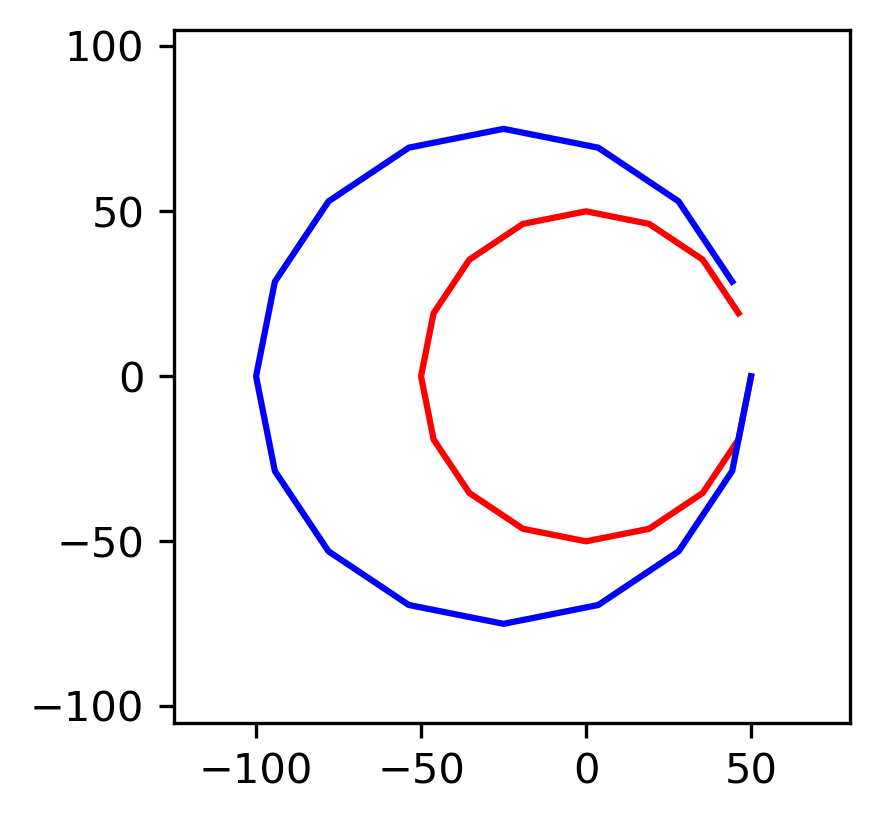

In [3]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)

geom0 = Point((0,0)).buffer(rad0)
geom0 = geom0.simplify(2)
plot_geometry(geom0, ax=ax, color='red')
print(f'geom0 : {len(geom0.exterior.coords.xy[0])-1} vertices')

vertex_count0 = len(geom0.exterior.coords.xy[0])-1

geom1 = Point((-25,0)).buffer(rad1)
geom1 = geom1.simplify(2)
plot_geometry(geom1, ax=ax, color='blue')
print(f'geom1 : {len(geom1.exterior.coords.xy[0])-1} vertices')

vertex_count1 = len(geom1.exterior.coords.xy[0])-1

vertex_count = max(vertex_count0, vertex_count1)

ax.set_xlim(-125,80)
ax.set_ylim(-105,105)

In [4]:
geoms0 = []
geoms1 = []
for i in range(nsamples): 
    geoms0.append(sample_geometry(geom0, sigma=sigma0))
    geoms1.append(sample_geometry(geom1, sigma=sigma1))

X0 = geoms_to_matrix(geoms0, vertex_count=vertex_count, aligned_geom=geom0, nsamples=nsamples)
X1 = geoms_to_matrix(geoms1, vertex_count=vertex_count, aligned_geom=geom0, nsamples=nsamples)

(-105.0, 105.0)

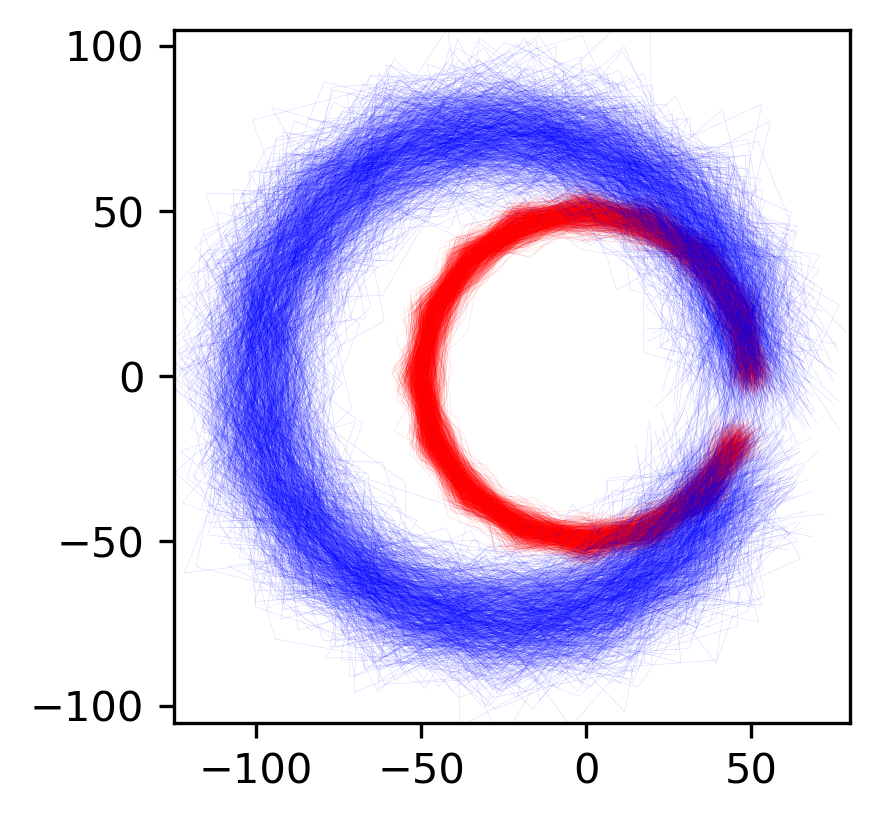

In [5]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)

plot_matrix_ensemble(X0, ax=ax, color=(1,0,0,0.2), lw=0.1)
plot_matrix_ensemble(X1, ax=ax, color=(0,0,1,0.2), lw=0.1)

ax.set_xlim(-125,80)
ax.set_ylim(-105,105)

(-105.0, 105.0)

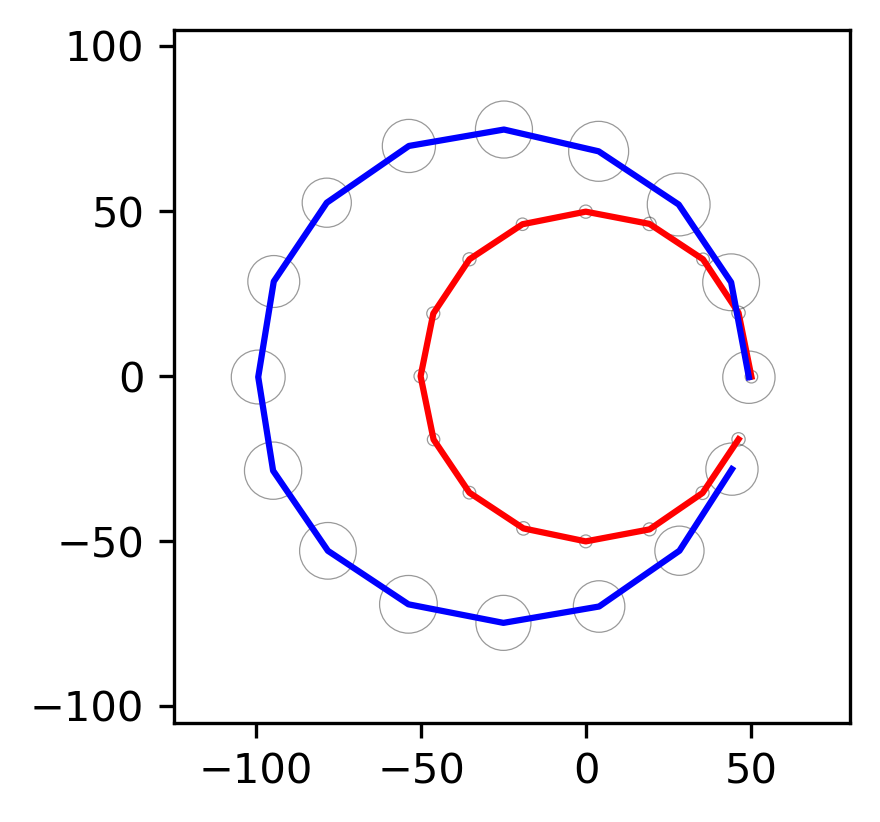

In [6]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)

plot_matrix(X0, ax=ax, show_stdev=True, color=(1,0,0,1))
plot_matrix(X1, ax=ax, show_stdev=True, color=(0,0,1,1))

ax.set_xlim(-125,80)
ax.set_ylim(-105,105)

In [9]:
X, K = update_EnKF(X0, X1)

Text(0.5, 1.0, '$\\sigma_{Red}$ = 3| $\\sigma_{Blue}$ = 10')

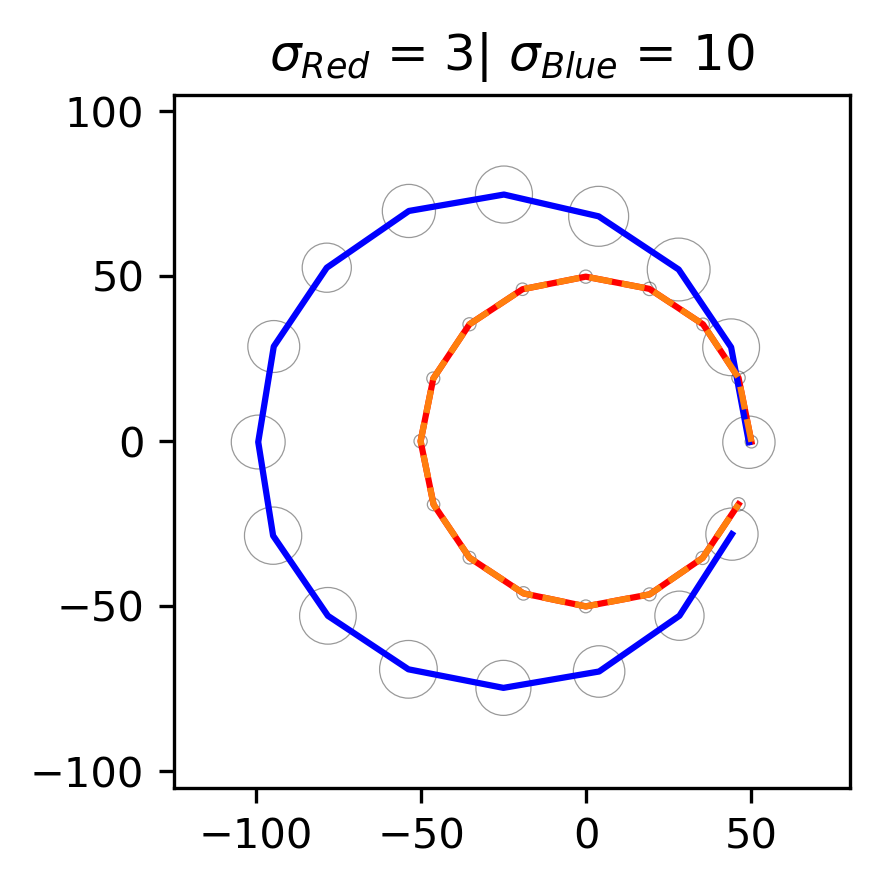

In [10]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)

plot_matrix(X0, ax=ax, show_stdev=True, color='red')
plot_matrix(X1, ax=ax, show_stdev=True, color='blue')
plot_matrix(X, ax=ax, color='tab:orange', ls='--')


ax.set_xlim(-125,80)
ax.set_ylim(-105,105)

ax.set_title(r'$\sigma_{Red}$ = ' + str(sigma0) + r'| $\sigma_{Blue}$ = ' + str(sigma1))

In [59]:
x = X.mean(axis=1, keepdims=True)
Ex = X - x
P = 1/(nsamples)*np.matmul(Ex, Ex.T)

### Start testing the simpler version: A line moves in a single direction

In [12]:
# Generate sample for yv
def calculate_adjusted(sigma_forward, sigma_measure, t, nsamples):
    np.random.seed(0)
    Xt = np.random.normal(2, sigma_forward, (len(t),nsamples))
    # Y = np.random.normal(2.5,sigmablue,(len(t),nsamples))
    Y = np.array([[2.5,2.4,2.45,2.1,2.6]]).T.repeat(nsamples, axis=1) + np.random.normal(0,sigma_measure, (len(t),nsamples))
    X,K = update_EnKF(Xt, Y)

    return Xt, Y, X, K

def plot_ensembles(ax, Xt, Y, X, K):
    for j in range(nsamples):
        ax.plot(t*10+1, Xt[:,j], color=(1,0,0,0.5), lw=0.1, marker='o', ms=1)
        ax.plot(t*10+1, Y[:,j], color=(0,0,1,0.5), lw=0.1, marker='o', ms=1)
        # ax.plot(t*10+1, X[:,j], color=(0,0,0,0.5), lw=0.1, marker='o', ms=1)
    
    ax.plot([-10,-10], [-10,-10], color=(0,0,1,0.5), lw=0.1, marker='o', ms=1, label='measurement perturbations')
    # ax.plot(t*10+1, Y.mean(axis=1), color=(0,1,1,1), ls='--', lw=1, label='measurement mean')
    ax.plot([-10,-10], [-10,-10], color=(1,0,0,0.5), lw=0.1, marker='o', ms=1, label='forward samples')
    # ax.plot(t*10+1, Xt.mean(axis=1), color=(1,1,0,1), ls='--', lw=1, label='forward ensemble mean')

    x = Xt.mean(axis=1) + np.matmul(K, (Y.mean(axis=1) - Xt.mean(axis=1)))
    
    # ax.plot(t*10+1, X.mean(axis=1), color=(0,0,0), ls='--', lw=1, label='adjusted mean')
    ax.plot(t*10+1, x, color=(0,0,0), ls='--', lw=1, label='adjusted mean')
    
    # ax.legend(fontsize=6, loc='lower right')
    ax.set_ylim(0,3.5)
    ax.set_xlim(0.5,5.5)
    
    # ax.text(3, 3, '# of samples=100', horizontalalignment='center')
    ax.set_xticks(np.arange(1,6))
    # ax.set_xlabel('Car number')
    # ax.set_ylabel('Car position\n' + r'at $t=t_0$')


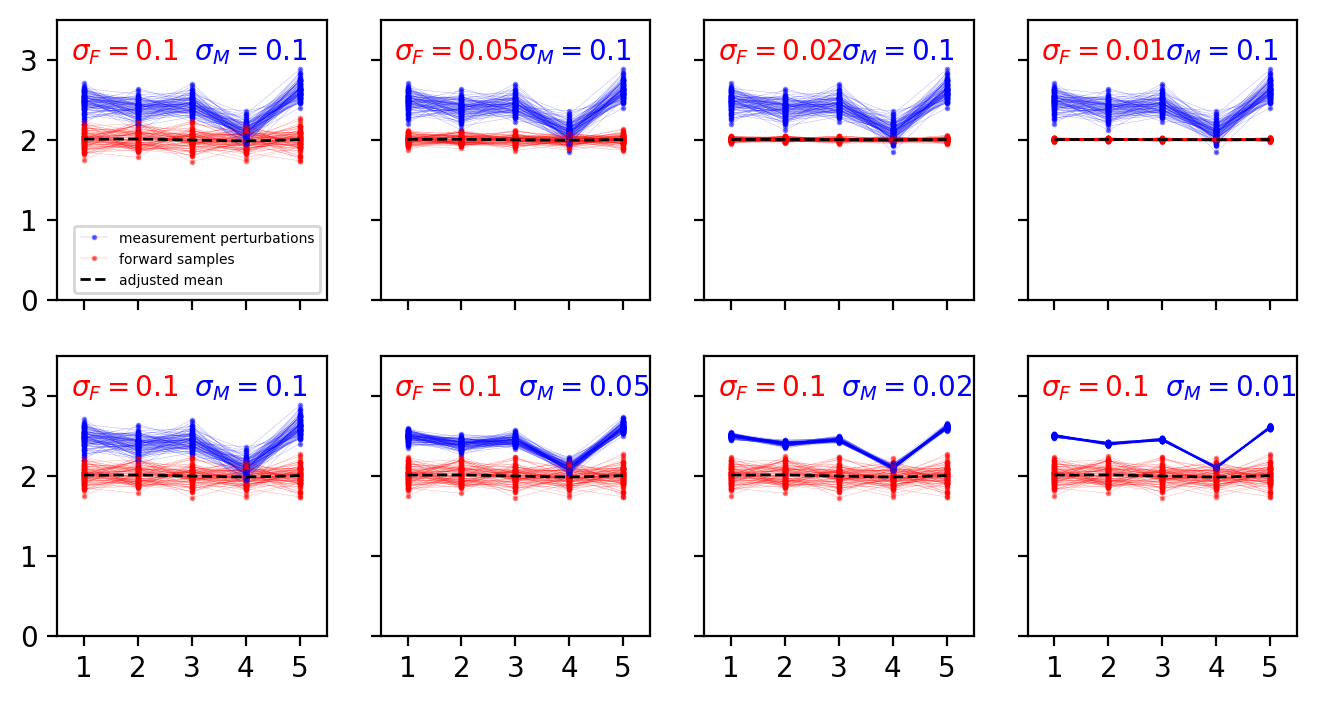

In [13]:
t = np.arange(0,0.5,0.1)
nsamples = 100
sigma_forward = 0.5
sigma_measure = 0.01


sigma_f = [0.1,0.05,0.02,0.01, 0.1,0.1,0.1,0.1]
sigma_m = [0.1,0.1,0.1,0.1, 0.1, 0.05, 0.02, 0.01]
fig, axes = plt.subplots(2,4, figsize=(8,4), dpi=200, sharex=True, sharey=True)

for ax,sigmaf,sigmam in zip(axes.flatten(), sigma_f, sigma_m):
    Xt, Y, X, K = calculate_adjusted(sigmaf,sigmam, t, nsamples)
    plot_ensembles(ax, Xt, Y, X, K)
    # ax.set_title(r'$\sigma_F=$' + f'{sigmaf}' + r' ${\sigma_M}=$' + f'{sigmam}')
    ax.text(0.75,3, r'$\sigma_F=$' + f'{sigmaf}', color='red', fontsize=10, horizontalalignment='left')
    ax.text(2.9,3, r' ${\sigma_M}=$' + f'{sigmam}', color='blue', fontsize=10, horizontalalignment='left')
    
axes[0,0].legend(loc='lower right', fontsize=5)

In [73]:
# fig, ax = plt.subplots(1,1, figsize=(4,2),dpi=200)

# ax.plot(t, Xt.mean(axis=1), 'r-')
# ax.plot(t, Y.mean(axis=1), 'b-')
# ax.plot(t, X.mean(axis=1), 'k--', lw=1)

In [74]:
t

array([0. , 0.1, 0.2, 0.3, 0.4])

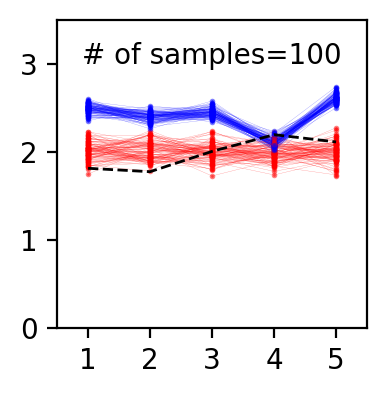

In [148]:
nsamples = Y.shape[1]

xt = Xt.mean(axis=1, keepdims=True)
y = Y.mean(axis=1, keepdims=True)

Ex = Xt - xt.repeat(nsamples, axis=1)
Ey = Y - y.repeat(nsamples, axis=1)

Px = 1/(nsamples-1)*np.matmul(Ex, Ex.T)
Py = 1/(nsamples-1)*np.matmul(Ey, Ey.T)
Pxy = 1/(nsamples-1)*np.matmul(Ex, Ey.T)

Py_inv = np.linalg.pinv(Py, hermitian=True)
K = np.matmul(Pxy, Py_inv)

X = Xt + np.matmul(K, (Xt - Y))

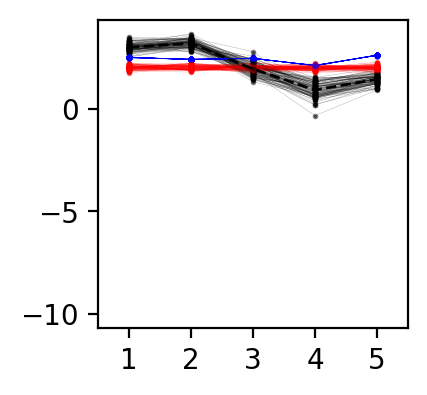

In [149]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi=200)
plot_ensembles(ax, Xt, Y, X)

In [73]:
Xt[:,0] + np.matmul(K, (Y[:,0] - Xt[:,0])), X[:,0]

(array([ 0.07684055,  9.36602358, -5.20480682,  0.1895689 ,  0.79221207,
         0.74086215,  3.63532191,  0.93141715,  0.48302919,  3.76421289]),
 array([ 0.07684055,  9.36602358, -5.20480682,  0.1895689 ,  0.79221207,
         0.74086215,  3.63532191,  0.93141715,  0.48302919,  3.76421289]))

In [125]:

nsamples = Y.shape[1]

xt = Xt.mean(axis=1, keepdims=True)
y = Y.mean(axis=1, keepdims=True)

Ex = Xt - xt.repeat(nsamples, axis=1)
Ey = Y - y.repeat(nsamples, axis=1)

Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
Pxy = 1/(nsamples)*np.matmul(Ex, Ey.T)

# max_Py = abs(Py).max()
# max_Pxy = abs(Pxy).max()
# Py /= max_Py
# Pxy /= max_Pxy

Py_inv = np.linalg.pinv(Py, hermitian=True)

assert(np.allclose(np.matmul(Py, Py_inv), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

# K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
K = np.matmul(Pxy, Py_inv)

# Note that Xt has additional +2 in it
# Remove that with the matrix C
C = np.eye(Y.shape[0], Xt.shape[0])
#### Update the state ensemble
# X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
X = Xt + np.matmul(K, (Y - Xt))

### TODO ####
# Fix invalid geometries

# X = validate_geoms_matrix(X, aligned_geom)

In [108]:
np.linalg.det(K)

0.00781918384352147